In [12]:
import numpy as np
%matplotlib inline
from pylab import *

from astropy import units as uu
from astropy import constants as cc

In [13]:
dat = np.loadtxt("s2n.dat")

In [14]:
f_l_units = uu.erg/uu.s/uu.angstrom/uu.cm**2

In [15]:
l,calibs = dat.T
l *= uu.angstrom
calibs = calibs/f_l_units/uu.s**0.5

In [16]:
epps = cc.h*cc.c/l

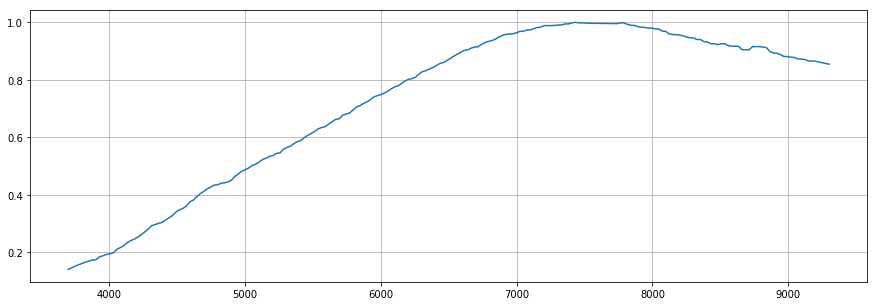

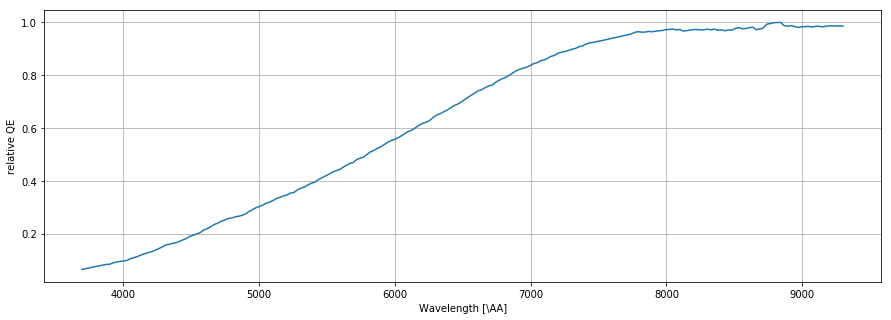

In [17]:
figure(figsize=(15,5))

phot_calib = calibs/epps
plot(l,calibs/calibs.max()) ; grid(True)

figure(figsize=(15,5))
plot(l,phot_calib/phot_calib.max()) ; grid(True)
xlabel(r"Wavelength [\AA]")
ylabel("relative QE")

# Grasp of SEDM

In [18]:
# Obstruction: https://www.evernote.com/shard/s13/sh/e0686797-ef64-4b1c-b32f-c2f1bef9fd7d/59e86b4e9c3cd4426ce9164050187d0e

In [36]:
D_tel = 60 * uu.imperial.inch

A_tel = (np.pi*(D_tel/2)**2 - np.pi*(D_tel/2*.4)**2).cgs

In [37]:
spectral_res = 100
pixels_per_res = 2.4
lam = 6000 * uu.Angstrom

BW_per_pixel = lam/ spectral_res / pixels_per_res

In [38]:
A_tel.cgs

<Quantity 15322.83416791 cm2>

In [39]:
BW_per_pixel

<Quantity 25. Angstrom>

In [41]:
A_tel * BW_per_pixel

<Quantity 383070.85419771 Angstrom cm2>

In [49]:
# So let's consider 6000 Angstrom as a fiducial wavelength. The calibration curve indicates that the calibration is:
lam = 6000 # Angstrom
calib = 1.55e15 # cm2 Angstrom sqrt(second)/erg

# So we need to estimate the instrument's "grasp" in units of cm2-Angstrom. This is simply:
Atel = 15322 # cm2
resolution = 100 # SEDM's spectral resolution in micropupil units
pixels_per_res = 2.4 # SEDM's micropupil sampling
BW = lam /  resolution / pixels_per_res

Grasp = Atel * BW
print("GRASP: %s cm2-Angstrom" % (Grasp))

# 6000 angstrom energy per photon
epp = 3.31e-12 #erg

## Source signal is enormous
f_lambda = 1 # erg/s/cm2/angstrom
n_lambda = f_lambda/epp
exptime = 1 # second

num_photon_max = n_lambda * Grasp * exptime
print("Under perfect conditions SEDM receives %1.2e photon" % num_photon_max)

snr_max = np.sqrt(num_photon_max)
print("  and thus SNR is %1.2e" % snr_max)


snr_emp = calib * f_lambda * np.sqrt(exptime)
print("  Calibrated SNR is: %1.2e" % snr_emp)



GRASP: 383050.0 cm2-Angstrom
Under perfect conditions SEDM receives 1.16e+17 photon
  and thus SNR is 3.40e+08
  Calibrated SNR is: 1.55e+15


# Energy per photon

In [23]:
hc = cc.h * cc.c
epp = hc/lam

In [24]:
epp.cgs

<Quantity 3.31074304e-12 erg>

#  input at wavelength lam

In [25]:
f_l = 1 * f_l_units
exptime = 1*uu.s

In [26]:
f_l

<Quantity 1. erg / (Angstrom cm2 s)>

In [27]:
ix = np.argmin(np.abs(l - lam))
calib = calibs[ix]
calib

<Quantity 1.5448951e+15 Angstrom cm2 s(1/2) / erg>

### In the case where the input spectrum is not affected by loses I compute the number of photons received. This represents an ideal situation where there are not atmospheric, reflective, fresnel, or other loses

In [28]:
num_photon = (f_l * exptime * BW_per_pixel * A_tel / epp).cgs
num_photon

<Quantity 1.15705402e+17>

In [29]:
snr_ideal = np.sqrt(num_photon)
snr_ideal

<Quantity 3.40154968e+08>

### I now use the Nugent curve to estimate the measured SNR

In [30]:
measured_signal_to_noise = calib * f_l * (exptime)**.5

In [31]:
measured_signal_to_noise

<Quantity 1.5448951e+15>

In [32]:
print("QE is: %s" % (measured_signal_to_noise/snr_ideal))

QE is: 4541739.052597924


--> Clearly something is wrong ^^^^^

### Pretend units of the calibration curve are such that 
$S/N = (calib\ curv \cdot input\ spectrum \cdot exptime)^{.5}$

In [33]:
cv = calib.value / f_l_units / uu.s

In [34]:
measured_signal_to_noise_janky = np.sqrt(cv * f_l * uu.s)

In [35]:
print("Janky approach yields a QE of %1.2f" % (measured_signal_to_noise_janky/snr_ideal))

Janky approach yields a QE of 0.12


This is a reasonable value, but not sure if this is correct